## Metric #1: Off-ice errors

**This notebook presents a full analysis of all 172 test pairs. For general intro and demo, see** `metric_off-ice-error.ipynb`.

### Analysis

#### 1. Basic information, importing modules

- Test area: **Kaskawulsh Glacier**
- Test packages: **CARST, Vmap, GIV, autoRIFT**
- Test pairs: 172 pairs in total; 43 pairs for each date range:
  - **Landsat 8 20180304-20180405**
  - **Landsat 8 20180812-20180818**
  - **Sentinel-2 20180304-20180314**
  - **Sentinel-2 20180508-20180627**

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import glaft
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd

#### 2. Load the feature tracking data list and off-ice area shapefile

Each row is a feature tracking test using a specific parameter combination described in each field.

In [3]:
# df = pd.read_csv('../manifest.csv', dtype=str)
df = pd.read_csv('../results_2022.csv', dtype=str)
df

Date Duration (days) Template size (px)  \
0    Sen2-20180304-20180314              10                 48   
1    Sen2-20180304-20180314              10                 48   
2    Sen2-20180304-20180314              10                 48   
3    Sen2-20180304-20180314              10                 48   
4    Sen2-20180304-20180314              10                 48   
..                      ...             ...                ...   
167  Sen2-20180508-20180627              50                 64   
168  Sen2-20180508-20180627              50                 32   
169  Sen2-20180508-20180627              50                 32   
170  Sen2-20180508-20180627              50                 64   
171  Sen2-20180508-20180627              50                 64   

    Template size (m) Pixel spacing (px) Pixel spacing (m) Prefilter  \
0                 480                 12               120       Gau   
1                 480                 12               120      NAOF   
2                 480                 12               120      None   
3                 480                  1                10       Gau   
4                 480                  1                10      NAOF   
..                ...                ...               ...       ...   
167               640                  8                80       Gau   
168               320                  4                40      NAOF   
169               320                  8                80      NAOF   
170               640                  4                40      NAOF   
171               640                  8                80      NAOF   

                 Subpixel  Software  \
0    16-node oversampling     CARST   
1    16-node oversampling     CARST   
2    16-node oversampling     CARST   
3    16-node oversampling     CARST   
4    16-node oversampling     CARST   
..                    ...       ...   
167                 pyrUP  autoRIFT   
168                 pyrUP  autoRIFT   
169                 pyrUP  autoRIFT   
170                 pyrUP  autoRIFT   
171                 pyrUP  autoRIFT   

                                                    Vx  \
0    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
1    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
2    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
3    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
4    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
..                                                 ...   
167  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
168  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
169  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
170  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
171  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   

                                                    Vy    SAV-uncertainty-x  \
0    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  0.32637951498361006   
1    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   0.2904061391872022   
2    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   0.4480050686250796   
3    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  0.19932657031566106   
4    /home/jovyan/Projects/PX_comparison/PX/CARST/2...    0.170416834102238   
..                                                 ...                  ...   
167  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  0.17952278944131322   
168  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  0.11496105665321626   
169  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  0.07502428079962462   
170  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  0.07284891177652728   
171  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  0.06232283079917451   

       SAV-uncertainty-y             SAV-peak-x             SAV-peak-y  \
0    0.35901746648197114   -0.07337931716612034    0.17662068283387966   
1      0.299206325223178   -0.05369981396402412    0.16505018603597588   
2    0.47890196990956785  -0

Load the off-ice area shapefile.

In [4]:
# off-ice area
in_shp = '../../data/shapefiles/bedrock_V1.shp'
# off_ice = gpd.read_file(in_shp)
# in_shp2 = '/home/jovyan/Projects/PX_comparison/Bedrock_shp/Kaskawulsh_RGI60_EPSG32607.shp'
# off_ice2 = gpd.read_file(in_shp2)

#### 3. Create a colormap for glacier speed

Now make a special `viridis` colormap designed for Kaskawulsh:

The velocity x component looks like this:

#### 4. Off-ice error for all 172 tests

**Vx and Vy:**

**Off-ice error**:

In [5]:
def plot_sav_batch(demo, df):

    fig, ax2 = plt.subplots(8, 6, figsize=(20, 28))

    n = 0

    for idx, row in demo.iterrows():
        label = '-'.join((row.Software, row['Template size (px)'], row['Pixel spacing (px)'], row.Prefilter)) + '\n' + row.Subpixel
        ax_sel = ax2[n // 6, n % 6]
        ax_sel.axis('equal')

        if row.Software == 'GIV':
            exp = glaft.Velocity(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), static_area=in_shp, kde_gridsize=60, thres_sigma=2.0)
            exp.static_terrain_analysis(plot='zoomed', ax=ax_sel)
        else:
            exp = glaft.Velocity(vxfile=row.Vx, vyfile=row.Vy, static_area=in_shp, kde_gridsize=60, thres_sigma=2.0)
            exp.static_terrain_analysis(plot='zoomed', ax=ax_sel)
        ax_sel.set_xlim(-1.5, 1.5)
        ax_sel.set_ylim(-1.5, 1.5)
        
        titletext = ax_sel.get_title()
        titletext = label + '\n' + titletext
        ax_sel.set_title(titletext)
        
        df.loc[idx, 'SAV-uncertainty-x'] = exp.metric_static_terrain_x
        df.loc[idx, 'SAV-uncertainty-y'] = exp.metric_static_terrain_y
        df.loc[idx, 'SAV-peak-x'] = exp.kdepeak_x
        df.loc[idx, 'SAV-peak-y'] = exp.kdepeak_y
        df.loc[idx, 'SAV-outlier-percent'] = exp.outlier_percent * 100

        n += 1

    for i in range(n, 48):
        ax_sel = ax2[i // 6, i % 6]
        fig.delaxes(ax_sel)
        
    plt.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    return fig, ax2, df

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Ru

/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_

/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_

/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_

/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh


/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/jovyan/.conda/envs/eztrack/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:239: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_

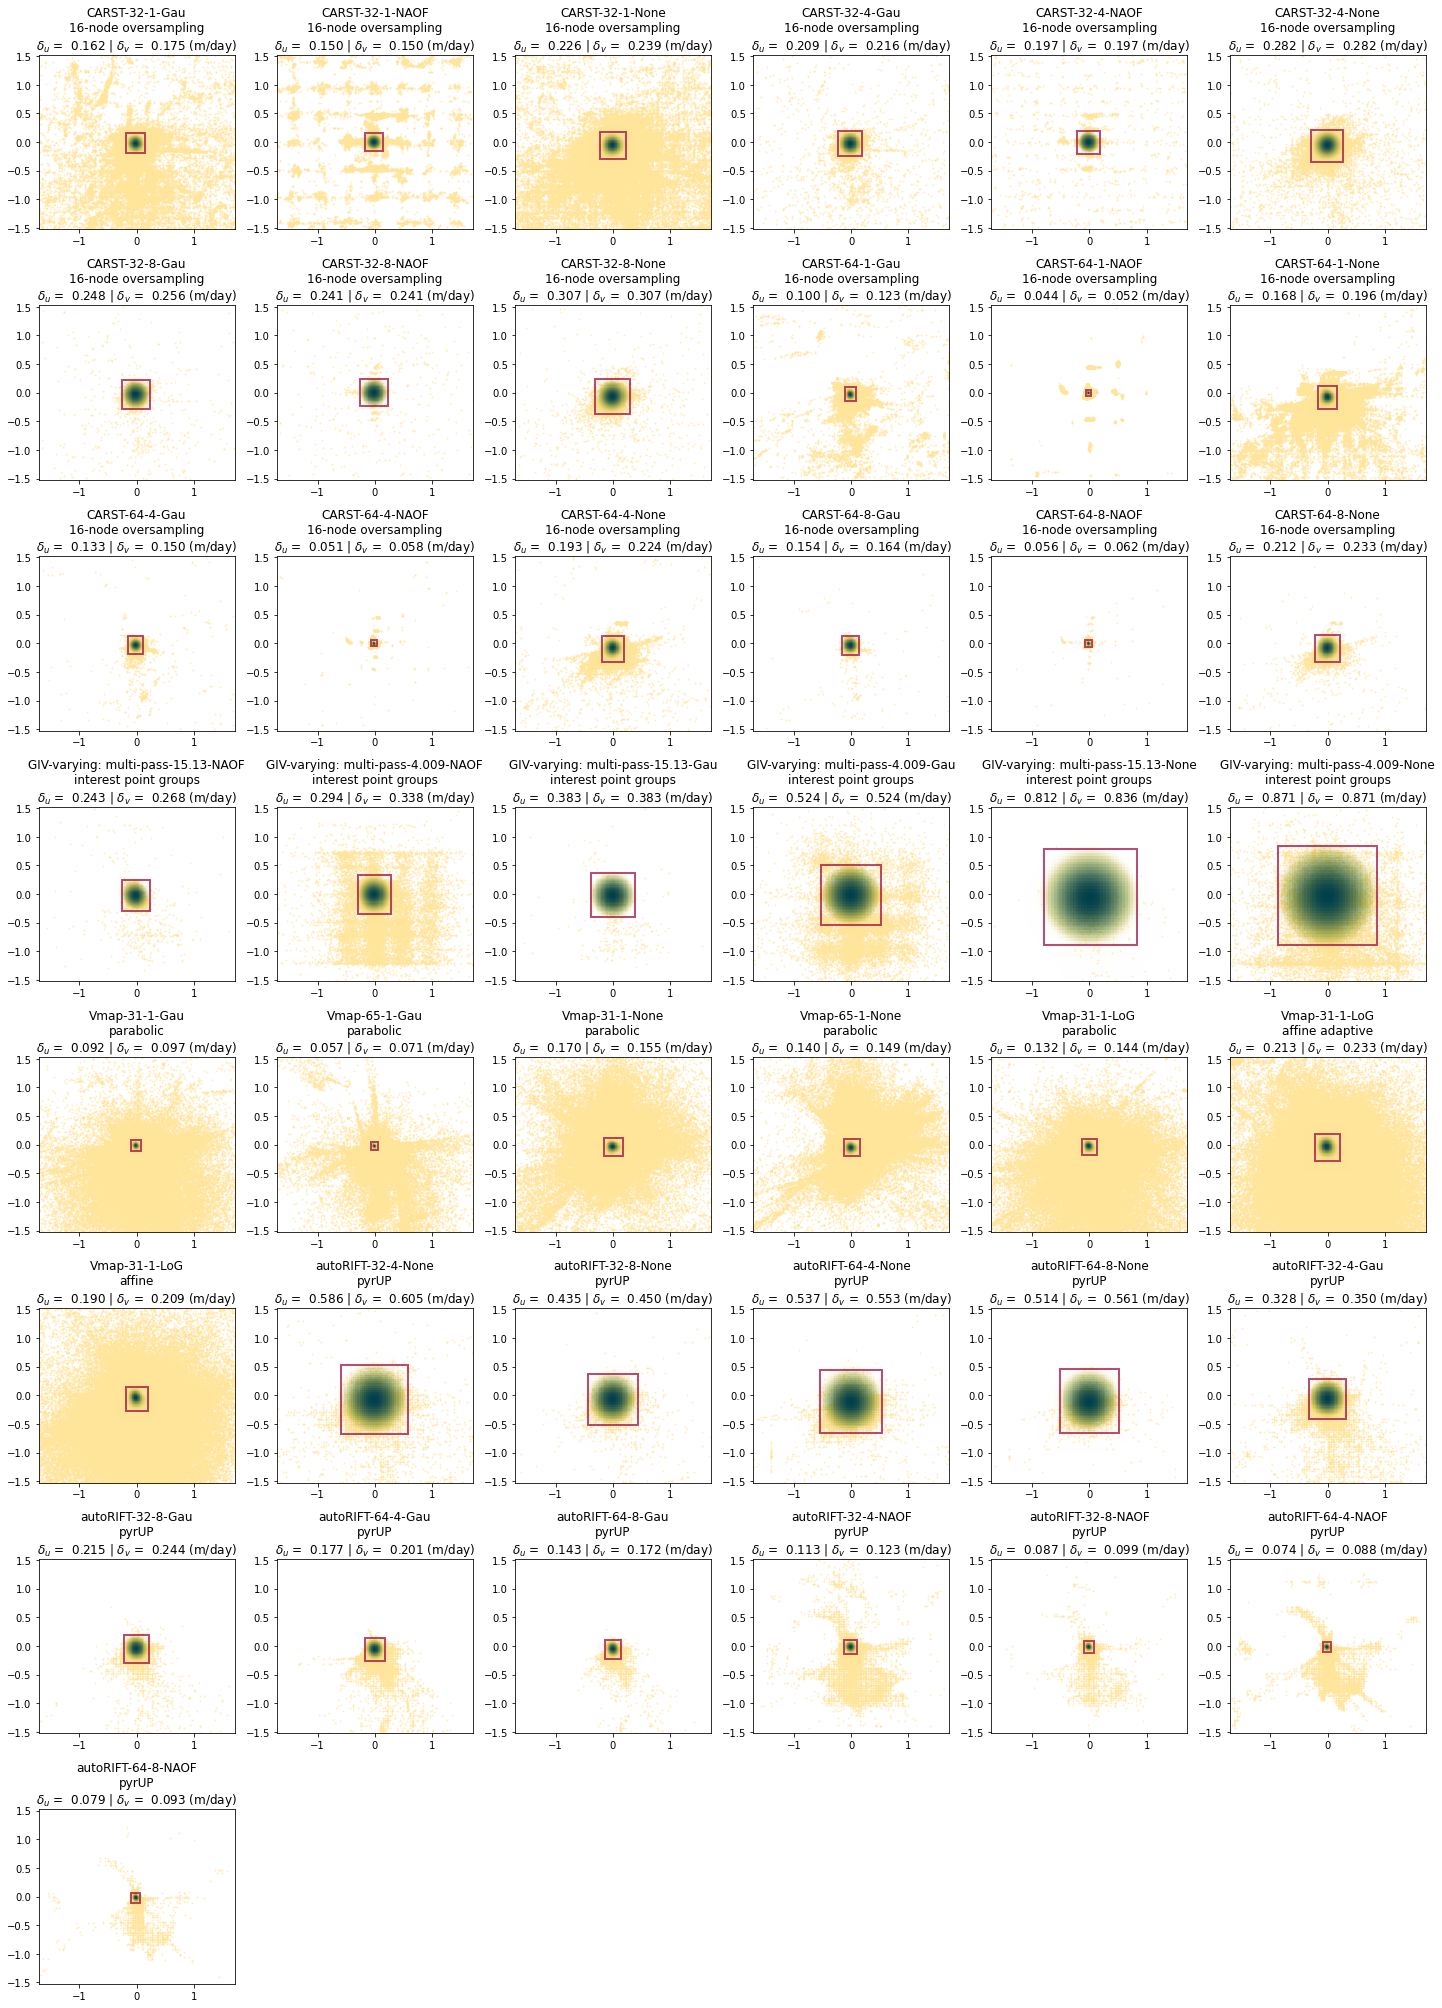

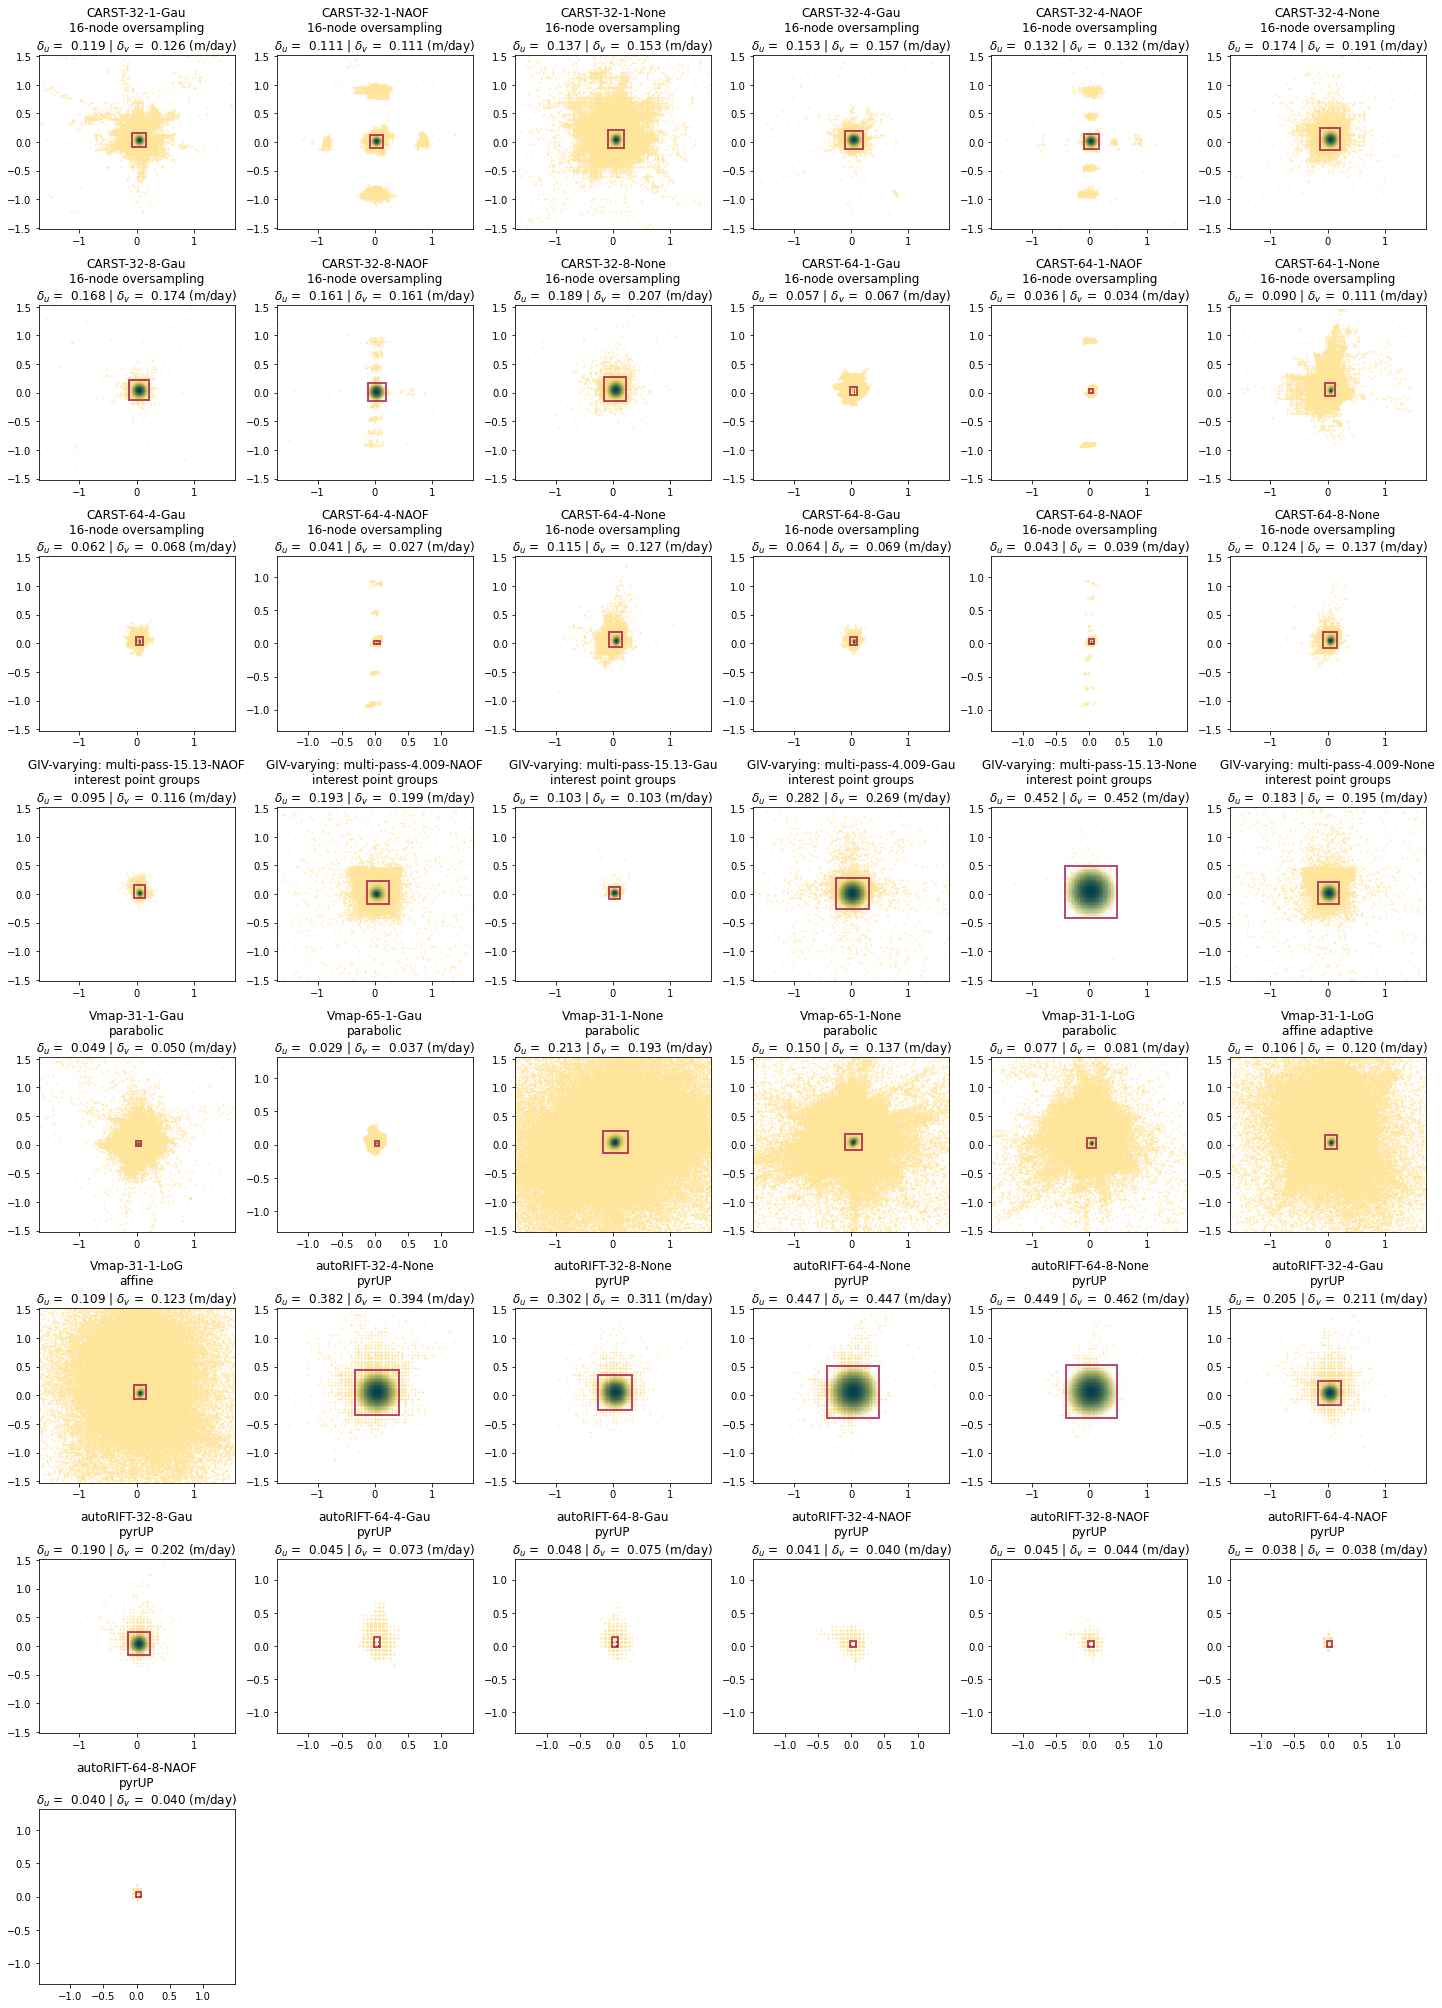

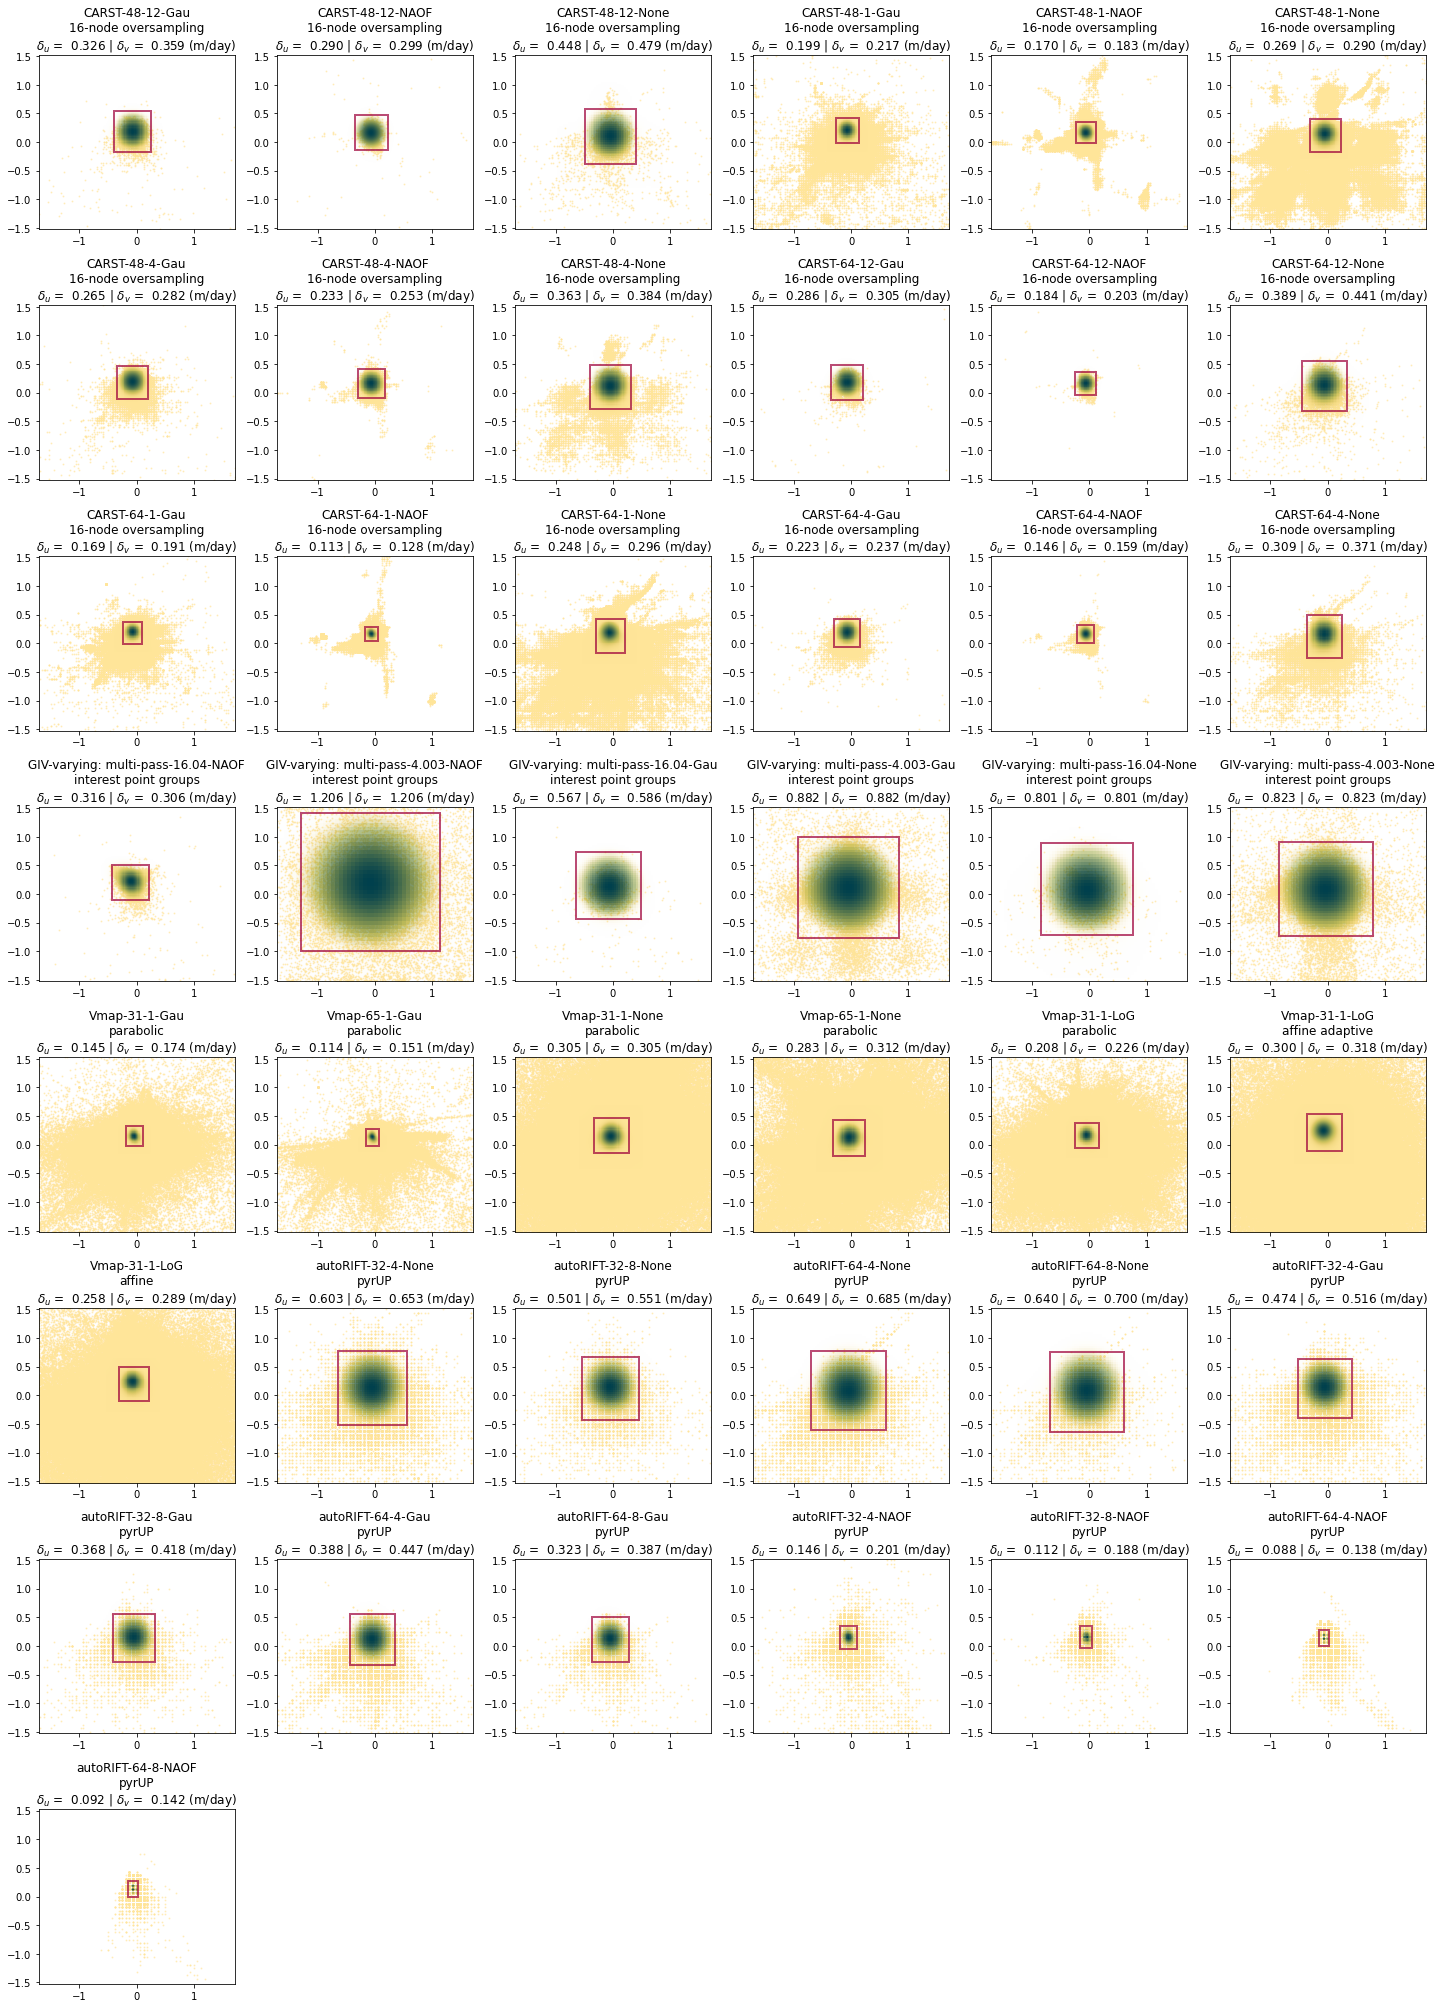

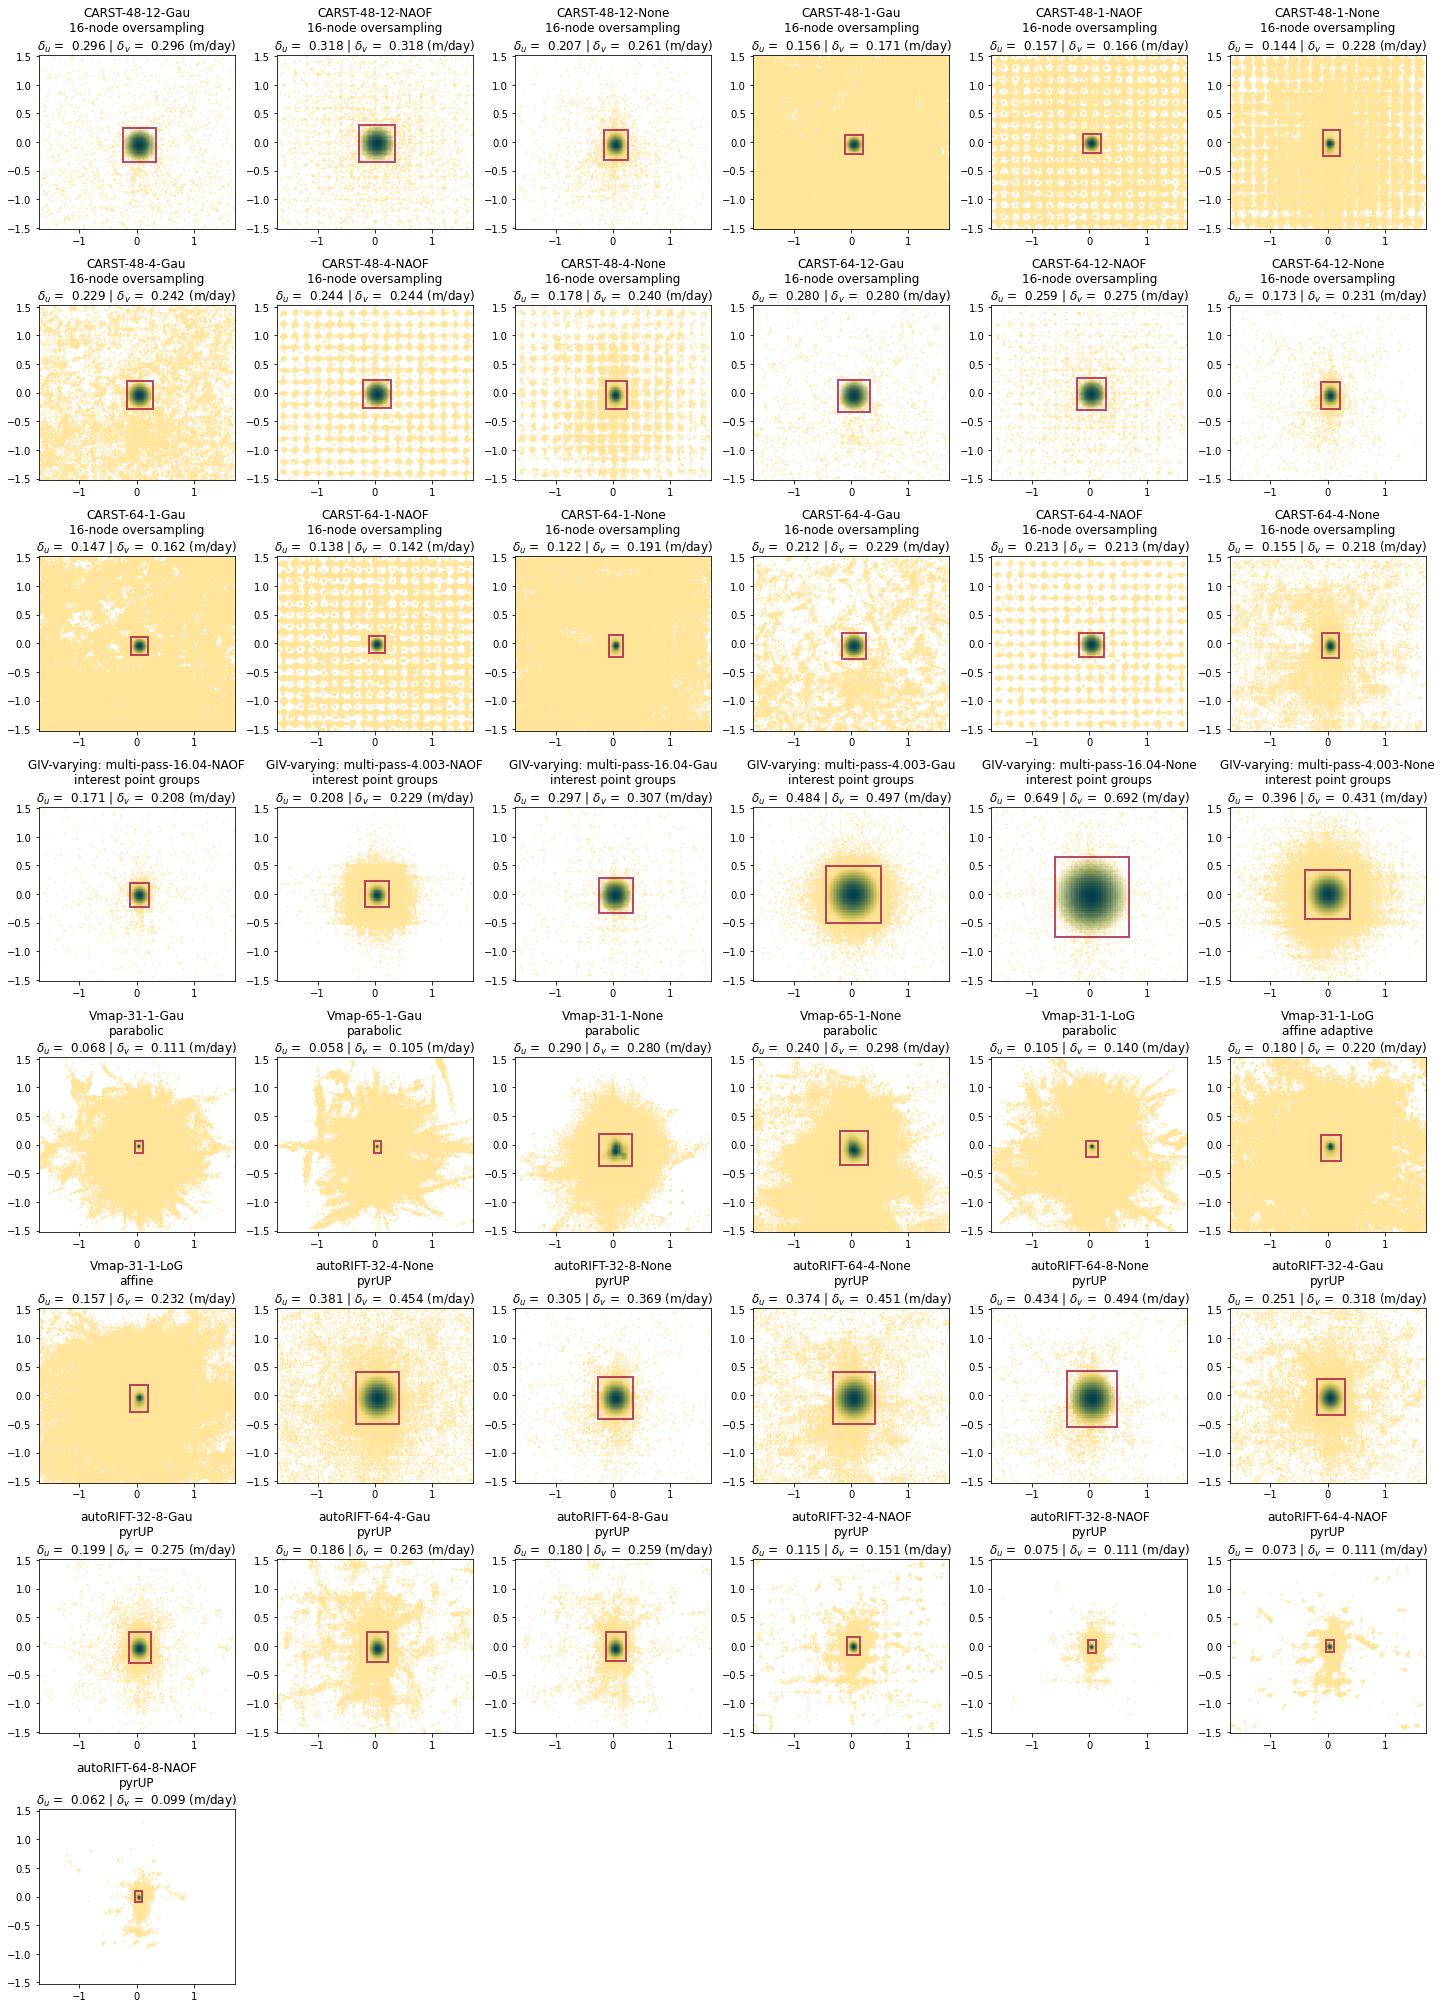

In [6]:
for datestr in ['LS8-20180304-20180405', 'LS8-20180802-20180818', 'Sen2-20180304-20180314', 'Sen2-20180508-20180627']:
    demo = df.loc[df['Date'] == datestr]
    fig, _, df = plot_sav_batch(demo, df)
    fig.savefig('figs/' + datestr + '-SAV.png')

Save the quantitative results (`OIE-x` and `OIE-y`):

In [7]:
df.to_csv('../results_2022.csv', index=False)
# df